# Generative Image to Image Translation with CycleGAN

In [0]:
!git clone https://github.com/pkmital/CycleGAN.git

Cloning into 'CycleGAN'...
remote: Enumerating objects: 48, done.
remote: Total 48 (delta 0), reused 0 (delta 0), pack-reused 48
Unpacking objects: 100% (48/48), done.


## Introduction
* we will make nonmakeup-> makeup

## Encoder

In [2]:
!pip install cadl
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as tfl
from cadl.cycle_gan import lrelu, instance_norm

    100% |████████████████████████████████| 153kB 5.1MB/s 
    100% |████████████████████████████████| 1.6MB 8.7MB/s 
    100% |████████████████████████████████| 1.1MB 11.8MB/s 
    100% |████████████████████████████████| 327kB 13.2MB/s 
    100% |████████████████████████████████| 3.2MB 8.9MB/s 
    100% |████████████████████████████████| 92kB 25.5MB/s 
    100% |████████████████████████████████| 204kB 22.1MB/s 
    100% |████████████████████████████████| 16.1MB 1.6MB/s 
    100% |████████████████████████████████| 5.6MB 6.1MB/s 
    100% |████████████████████████████████| 71kB 22.2MB/s 
    100% |████████████████████████████████| 16.1MB 1.8MB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for bs4 ... - done
  Stored in directory: /root/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
  Running setup.py b

/usr/local/lib/python3.6/dist-packages/cadl/cycle_gan.py:21: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
    re

In [0]:
def encoder(x, n_filters=32, k_size=3, normalizer_fn=instance_norm,
        activation_fn=lrelu, scope=None, reuse=None):
    with tf.variable_scope(scope or 'encoder', reuse=reuse):
        h = tf.pad(x, [[0, 0], [k_size, k_size], [k_size, k_size], [0, 0]],
                "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters,
                kernel_size=7,
                stride=1,
                padding='VALID',
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='2',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 4,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='3',
                reuse=reuse)
    return h

## Residual Blocks and Transformer

In [0]:
def residual_block(x, n_channels=128, normalizer_fn=instance_norm,
        activation_fn=lrelu, kernel_size=3, scope=None, reuse=None):
    with tf.variable_scope(scope or 'residual', reuse=reuse):
        h = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_channels,
                kernel_size=kernel_size,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                padding='VALID',
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_channels,
                kernel_size=kernel_size,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                padding='VALID',
                activation_fn=None,
                scope='2',
                reuse=reuse)
        h = tf.add(x, h)
    return h

In [0]:
def transform(x, img_size=256, reuse=None):
    h = x
    if img_size >= 256:
        n_blocks = 9
    else:
        n_blocks = 6
    for block_i in range(n_blocks):
        with tf.variable_scope('block_{}'.format(block_i), reuse=reuse):
            h = residual_block(h, reuse=reuse)
    return h

## Decoder

In [0]:
def decoder(x, n_filters=32, k_size=3, normalizer_fn=instance_norm,
        activation_fn=lrelu, scope=None, reuse=None):
    with tf.variable_scope(scope or 'decoder', reuse=reuse):
        h = tfl.conv2d_transpose(
                inputs=x,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d_transpose(
                inputs=h,
                num_outputs=n_filters,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='2',
                reuse=reuse)
        h = tf.pad(h, [[0, 0], [k_size, k_size], [k_size, k_size], [0, 0]],
                "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=3,
                kernel_size=7,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                padding='VALID',
                normalizer_fn=normalizer_fn,
                activation_fn=tf.nn.sigmoid,
                scope='3',
                reuse=reuse)
    return h

In [0]:
def generator(x, scope=None, reuse=None):
    img_size = x.get_shape().as_list()[1]
    with tf.variable_scope(scope or 'generator', reuse=reuse):
        h = encoder(x, reuse=reuse)
        h = transform(h, img_size, reuse=reuse)
        h = decoder(h, reuse=reuse)
    return h

## PatchGAN, Receptive Field Sizes, and the Discriminator

In [0]:
def discriminator(x, n_filters=64, k_size=4, activation_fn=lrelu,
        normalizer_fn=instance_norm, scope=None, reuse=None):
    with tf.variable_scope(scope or 'discriminator', reuse=reuse):
        h = tfl.conv2d(
                inputs=x,
                num_outputs=n_filters,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=None,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='2',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 4,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='3',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 8,
                kernel_size=k_size,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='4',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=1,
                kernel_size=k_size,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=tf.nn.sigmoid,
                scope='5',
                reuse=reuse)
        return h

## Connecting the Pieces

In [0]:
img_size = 256
X_real = tf.placeholder(name='X', shape=[1, img_size, img_size, 3], dtype=tf.float32)
Y_real = tf.placeholder(name='Y', shape=[1, img_size, img_size, 3], dtype=tf.float32)

In [0]:
X_fake = generator(Y_real, scope='G_yx')
Y_fake = generator(X_real, scope='G_xy')

In [0]:
X_cycle = generator(Y_fake, scope='G_yx', reuse=True)
Y_cycle = generator(X_fake, scope='G_xy', reuse=True)

In [0]:
D_X_real = discriminator(X_real, scope='D_X')
D_Y_real = discriminator(Y_real, scope='D_Y')
D_X_fake = discriminator(X_fake, scope='D_X', reuse=True)
D_Y_fake = discriminator(Y_fake, scope='D_Y', reuse=True)

In [0]:
l1 = 10.0
loss_cycle = tf.reduce_mean(l1 * tf.abs(X_real - X_cycle)) + \
             tf.reduce_mean(l1 * tf.abs(Y_real - Y_cycle))
loss_G_xy = tf.reduce_mean(tf.square(D_Y_fake - 1.0)) + loss_cycle
loss_G_yx = tf.reduce_mean(tf.square(D_X_fake - 1.0)) + loss_cycle

In [0]:
X_fake_sample = tf.placeholder(name='X_fake_sample',
        shape=[None, img_size, img_size, 3], dtype=tf.float32)
Y_fake_sample = tf.placeholder(name='Y_fake_sample',
        shape=[None, img_size, img_size, 3], dtype=tf.float32)

In [0]:
D_X_fake_sample = discriminator(X_fake_sample, scope='D_X', reuse=True)
D_Y_fake_sample = discriminator(Y_fake_sample, scope='D_Y', reuse=True)

In [0]:
loss_D_Y = (tf.reduce_mean(tf.square(D_Y_real - 1.0)) + \
            tf.reduce_mean(tf.square(D_Y_fake_sample))) / 2.0
loss_D_X = (tf.reduce_mean(tf.square(D_X_real - 1.0)) + \
            tf.reduce_mean(tf.square(D_X_fake_sample))) / 2.0

## Optimizer

In [0]:
tf.reset_default_graph()
from cadl.cycle_gan import cycle_gan
net = cycle_gan(img_size=img_size)

In [18]:
list(net.items())

[('G_vars',
  [<tf.Variable 'G_xy/encoder/1/Conv/weights:0' shape=(7, 7, 3, 32) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/1/instance_norm/scale:0' shape=(32,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/1/instance_norm/offset:0' shape=(32,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/Conv/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/instance_norm/scale:0' shape=(64,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/instance_norm/offset:0' shape=(64,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/Conv/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/instance_norm/scale:0' shape=(128,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/instance_norm/offset:0' shape=(128,) dtype=float32_ref>,
   <tf.Variable 'G_xy/block_0/residual/1/Conv/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
   <tf.Variable 'G_xy/block_0/residual/1/instance_norm/scale:0' shape=(128,) dtype=float32_ref

In [0]:
training_vars = tf.trainable_variables()
D_X_vars = [v for v in training_vars if v.name.startswith('D_X')]
D_Y_vars = [v for v in training_vars if v.name.startswith('D_Y')]
G_xy_vars = [v for v in training_vars if v.name.startswith('G_xy')]
G_yx_vars = [v for v in training_vars if v.name.startswith('G_yx')]
G_vars = G_xy_vars + G_yx_vars

In [0]:
learning_rate = 0.001
D_X = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_D_X'], var_list=D_X_vars)
D_Y = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_D_Y'], var_list=D_Y_vars)
G = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_G'], var_list=G_vars)

In [21]:
print(G)

name: "Adam_2"
op: "NoOp"
input: "^Adam_2/update_G_xy/encoder/1/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/1/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/1/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/2/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/2/instance_norm/scale/Apply

In [0]:
# How many fake generations to keep around
capacity = 50

# Storage for fake generations
fake_Xs = capacity * [np.zeros((1, img_size, img_size, 3), dtype=np.float32)]
fake_Ys = capacity * [np.zeros((1, img_size, img_size, 3), dtype=np.float32)]

## Batch Generator

In [0]:
from cadl.cycle_gan import batch_generator_dataset, batch_generator_random_crop

### Load Dataset

In [24]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22298 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [0]:
!mkdir -p drive 
!google-drive-ocamlfuse drive 

In [26]:
cd drive/Colab Notebooks

/content/drive/Colab Notebooks


In [27]:
!ls

 checkpoint				       x19.png	 y14.png
 CycleGan_garam.ipynb			       x1.png	 y15.png
'CycleGan_garam.ipynb의 사본'		       x20.png	 y16.png
 events.out.tfevents.1543215299.7b4bc09c7328   x21.png	 y17.png
 events.out.tfevents.1543215999.7b4bc09c7328   x22.png	 y18.png
 events.out.tfevents.1543218031.7b4bc09c7328   x23.png	 y19.png
 events.out.tfevents.1543219745.7b4bc09c7328   x24.png	 y1.png
 events.out.tfevents.1543220655.7b4bc09c7328   x25.png	 y20.png
 events.out.tfevents.1543230328.1d2c4835e494   x26.png	 y21.png
 events.out.tfevents.1543231376.1d2c4835e494   x27.png	 y22.png
'Hello, Colaboratory의 사본'		       x28.png	 y23.png
 model_181126_001.ckpt-0.data-00000-of-00001   x29.png	 y24.png
 model_181126_001.ckpt-0.index		       x2.png	 y25.png
 model_181126_001.ckpt-0.meta		       x30.png	 y26.png
 model_181126_002.ckpt-0.data-00000-of-00001   x31.png	 y27.png
 model_181126_002.ckpt-0.index		       x32.png	 y28.png
 model_181126_002.ckpt-0.meta		       x33.png	 y29.png
 model_181126_0

In [28]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.image 
import seaborn as sns
from PIL import Image
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
   

count : 0 item : f2-023-01-sz1.jpg
count : 1 item : f2-025-01-sz1.jpg
count : 2 item : f2-024-01-sz1.jpg
count : 3 item : f2-026-01-sz1.jpg
count : 4 item : f2-028-01-sz1.jpg
count : 5 item : f2-027-01-sz1.jpg
count : 6 item : f2-033-01-sz1.jpg
count : 7 item : f2-030-01-sz1.jpg
count : 8 item : f2-032-01-sz1.jpg
count : 9 item : f2-029-01-sz1.jpg
count : 10 item : f2-031-01-sz1.jpg
count : 11 item : f2-034-01-sz1.jpg
count : 12 item : f2-035-01-sz1.jpg
count : 13 item : f2-037-01-sz1.jpg
count : 14 item : f2-036-01-sz1.jpg
count : 15 item : f2-038-01-sz1.jpg
count : 16 item : m2-038-01-sz1.jpg
count : 17 item : m2-036-01-sz1.jpg
count : 18 item : m2-039-01-sz1.jpg
count : 19 item : m2-037-01-sz1.jpg
count : 20 item : m2-042-01-sz1.jpg
count : 21 item : m2-044-01-sz1.jpg
count : 22 item : m2-041-01-sz1.jpg
count : 23 item : m2-045-01-sz1.jpg
count : 24 item : m2-043-01-sz1.jpg
count : 25 item : m2-040-01-sz1.jpg
count : 26 item : m2-046-01-sz1.jpg
count : 27 item : m2-048-01-sz1.jpg
co

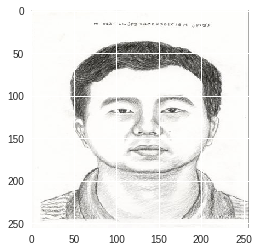

In [29]:
import os

path = '/content/drive/data/sketch_nonpair'
ds_X = np.array([])
count = 0
for item in os.listdir(path):
  print("count : {} item : {}".format(count, item))
  count += 1
  # if count > 10:
    # break
  imgpath = path+'/'+item
  img = Image.open(imgpath)
  img = img.resize((256,256))
  arr = np.array(img)
  img = Image.fromarray(arr, 'RGB')
  arr = arr / 256
  # plt.imshow(img)
  plt.imshow(arr)
  ds_X = np.append(ds_X, arr)

In [30]:
print(ds_X)

[0.71875    0.71875    0.7109375  ... 0.69140625 0.69140625 0.69140625]


In [31]:
ds_X = ds_X.reshape(-1,256,256,3)
print(ds_X.shape)

(43, 256, 256, 3)


count : 0 item : f-005-01.jpg
count : 1 item : f-006-01.jpg
count : 2 item : f-007-01.jpg
count : 3 item : f-009-01.jpg
count : 4 item : f-008-01.jpg
count : 5 item : f-010-01.jpg
count : 6 item : f-011-01.jpg
count : 7 item : f-012-01.jpg
count : 8 item : f-013-01.jpg
count : 9 item : f-015-01.jpg
count : 10 item : f-014-01.jpg
count : 11 item : f-016-01.jpg
count : 12 item : f-017-01.jpg
count : 13 item : f-018-01.jpg
count : 14 item : f-020-01.jpg
count : 15 item : f-019-01.jpg
count : 16 item : f-022-01.jpg
count : 17 item : f-021-01.jpg
count : 18 item : m-009-01.jpg
count : 19 item : m-008-01.JPG
count : 20 item : m-012-01.jpg
count : 21 item : m-011-01.jpg
count : 22 item : m-015-01.jpg
count : 23 item : m-013-01.jpg
count : 24 item : m-014-01.jpg
count : 25 item : m-017-01.jpg
count : 26 item : m-016-01.jpg
count : 27 item : m-018-01.jpg
count : 28 item : m-019-01.jpg
count : 29 item : m-021-01.jpg
count : 30 item : m-022-01.jpg
count : 31 item : m-023-01.jpg
count : 32 item : 

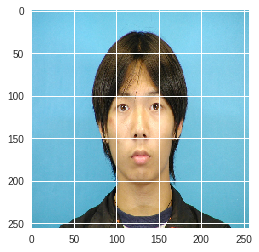

In [32]:
path = '/content/drive/data/photo_nonpair'
ds_Y = np.array([])
count = 0
for item in os.listdir(path):
  print("count : {} item : {}".format(count, item))
  count += 1
  # if count > 10:
    # break
  imgpath = path+'/'+item
  img = Image.open(imgpath)
  img = img.resize((256,256))
  arr = np.array(img)
  img = Image.fromarray(arr, 'RGB')
  arr = arr / 256
  # plt.imshow(img)
  plt.imshow(arr)
  ds_Y = np.append(ds_Y, arr)

In [33]:
ds_Y = ds_Y.reshape(-1,256,256,3)
print(ds_Y.shape)


(44, 256, 256, 3)


In [34]:
X_i, Y_i = next(batch_generator_dataset(ds_X, ds_Y))
X_i.shape, Y_i.shape

((1, 256, 256, 3), (1, 256, 256, 3))

## Training

In [0]:
pwd

'/content/drive/Colab Notebooks/drive/Colab Notebooks'

In [0]:
idx = 0
it_i = 0
n_epochs =200
ckpt_path = './'

In [0]:
n_epochs = 400

In [0]:
# Train
# 21:45 약 400 epochs
with tf.Session() as sess:
    # Build an init op for our variables
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    sess.run(init_op)
    
    # We'll also save our model so we can load it up again
    saver = tf.train.Saver()

#     saver = tf.train.import_meta_graph('./model_181126_003.ckpt-0.meta')
#     saver.restore(sess, './model2.ckpt-300')

  
  
    saver.restore(sess,'./model_181126_004.ckpt-0')
#     saver.restore(sess,tf.train.latest_checkpoint('./'))
    
    writer = tf.summary.FileWriter(ckpt_path)



    
    for epoch_i in range(n_epochs):
        print("epoch : ", epoch_i)
        # You'll want to use the approriate batch generator here!
        for X, Y in batch_generator_dataset(ds_X, ds_Y):

            # First generate in both directions
            X_fake, Y_fake = sess.run(
                [net['X_fake'], net['Y_fake']],
                feed_dict={net['X_real']: X,
                           net['Y_real']: Y})

            # Now sample from history
            if it_i < capacity:
                # Not enough samples yet, fill up history buffer
                fake_Xs[idx] = X_fake
                fake_Ys[idx] = Y_fake
                idx = (idx + 1) % capacity
            elif np.random.random() > 0.5:
                # Swap out a random idx from history
                rand_idx = np.random.randint(0, capacity)
                fake_Xs[rand_idx], X_fake = X_fake, fake_Xs[rand_idx]
                fake_Ys[rand_idx], Y_fake = Y_fake, fake_Ys[rand_idx]
            else:
                # Use current generation
                pass

            # Optimize G Networks
            loss_G = sess.run(
                [net['loss_G'], G],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['Y_fake_sample']: Y_fake,
                    net['X_fake_sample']: X_fake
                })[0]

            # Optimize D_Y
            loss_D_Y = sess.run(
                [net['loss_D_Y'], D_Y],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['Y_fake_sample']: Y_fake
                })[0]

            # Optimize D_X
            loss_D_X = sess.run(
                [net['loss_D_X'], D_X],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['X_fake_sample']: X_fake
                })[0]

            print(it_i, 'G:', loss_G, 'D_X:', loss_D_X, 'D_Y:', loss_D_Y)

            # Update summaries
            if it_i % 100 == 0:
                summary = sess.run(
                    net['summaries'],
                    feed_dict={
                        net['X_real']: X,
                        net['Y_real']: Y,
                        net['X_fake_sample']: X_fake,
                        net['Y_fake_sample']: Y_fake
                    })
                writer.add_summary(summary, it_i)
            it_i += 1

        # Save
        if epoch_i % 50 == 0:
            saver.save(
                sess,
                os.path.join(ckpt_path, 'model_181126_004.ckpt'),
                global_step=epoch_i)
            
        # Show generative images:        
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        
        print('epochs: ', epoch_i)
        axs[0][0].set_title('X Real')
        # axs[0][0].imshow(np.clip(X[0], 0.0, 1.0))
        axs[0][0].imshow(X[0])
        axs[0][0].grid(False)

        axs[0][1].set_title('X Fake')
        # x_fake = (X_fake[0] + abs(X_fake[0].min())) / (X_fake[0].max() + abs(X_fake[0].min()))
        # axs[0][1].imshow(x_fake)
        axs[0][1].imshow(np.clip(X_fake[0], 0.0, 1.0))
        axs[0][1].grid(False)
        img = Image.fromarray(X_fake[0],"RGB")
        Fake_X = "x" + str(epoch_i) + ".png"
        img.save(Fake_X)
        # axs[0][1].imshow(img) 
        print('epochs:::: ', epoch_i)
        
        
        axs[1][0].set_title('Y')
        # axs[1][0].imshow(np.clip(Y[0], 0.0, 1.0))
        axs[1][0].imshow(Y[0])
        axs[1][0].grid(False)
        
        axs[1][1].set_title('Y Fake')
        # y_fake = (Y_fake[0] + abs(Y_fake[0].min())) / (Y_fake[0].max() + abs(Y_fake[0].min()))
        # axs[1][1].imshow(y_fake)
        axs[1][1].imshow(np.clip(Y_fake[0], 0.0, 1.0))
        axs[1][1].grid(False)
        img = Image.fromarray(Y_fake[0],"RGB")
        Fake_Y = "y" + str(epoch_i) + ".png"
        img.save(Fake_Y)
        # axs[1][1].imshow(img)
        fig.show();

INFO:tensorflow:Restoring parameters from ./model_181126_004.ckpt-0
epoch :  0
0 G: 2.3015459 D_X: 0.18750489 D_Y: 0.32946873
1 G: 2.4022896 D_X: 0.1378904 D_Y: 0.31330442
2 G: 2.3057053 D_X: 0.16213846 D_Y: 0.52273506
3 G: 2.372222 D_X: 0.15376586 D_Y: 0.30656976
4 G: 2.3648536 D_X: 0.14162606 D_Y: 0.22886656
5 G: 1.7172949 D_X: 0.17627642 D_Y: 0.6118069
6 G: 1.9848568 D_X: 0.13383448 D_Y: 0.44944888
7 G: 2.3340683 D_X: 0.30128658 D_Y: 0.30648834
8 G: 2.2780411 D_X: 0.12521213 D_Y: 0.23055151
9 G: 2.3175468 D_X: 0.13059877 D_Y: 0.23951551
10 G: 2.3205159 D_X: 0.21902193 D_Y: 0.46084672
11 G: 2.3552535 D_X: 0.14694114 D_Y: 0.2624452
12 G: 2.2013159 D_X: 0.13348769 D_Y: 0.21524987
13 G: 2.3149962 D_X: 0.14135075 D_Y: 0.19744545
14 G: 2.1006944 D_X: 0.1965937 D_Y: 0.618287
15 G: 2.3075404 D_X: 0.15959927 D_Y: 0.24610901
16 G: 2.696416 D_X: 0.17607248 D_Y: 0.21467105
17 G: 2.1831458 D_X: 0.17451403 D_Y: 0.32522732
18 G: 2.041757 D_X: 0.14635438 D_Y: 0.3060585
19 G: 2.5757198 D_X: 0.156066

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


epoch :  1
43 G: 2.3507125 D_X: 0.13855138 D_Y: 0.20960307
44 G: 2.3446312 D_X: 0.16409548 D_Y: 0.2050302
45 G: 1.8817246 D_X: 0.15651363 D_Y: 0.46114135
46 G: 1.9268255 D_X: 0.12984101 D_Y: 0.22052237
47 G: 2.1082385 D_X: 0.12938246 D_Y: 0.3330982
48 G: 2.589314 D_X: 0.19686648 D_Y: 0.27213064
49 G: 2.3242872 D_X: 0.12421991 D_Y: 0.4632516
50 G: 2.4136775 D_X: 0.15437967 D_Y: 0.7210003
51 G: 2.5209966 D_X: 0.12538753 D_Y: 0.6050776
52 G: 2.1103268 D_X: 0.11893667 D_Y: 0.37469244
53 G: 1.7110329 D_X: 0.13193423 D_Y: 0.1955754
54 G: 1.9625337 D_X: 0.15282539 D_Y: 0.6394502
55 G: 1.6486294 D_X: 0.12000263 D_Y: 0.7122674
56 G: 2.0699432 D_X: 0.17586231 D_Y: 0.39153457
57 G: 2.0461326 D_X: 0.20876871 D_Y: 0.6563897
58 G: 1.7112136 D_X: 0.13701545 D_Y: 0.637954
59 G: 2.1679423 D_X: 0.12374629 D_Y: 0.70053273
60 G: 2.150128 D_X: 0.12968707 D_Y: 0.6616387
61 G: 2.2034879 D_X: 0.15037647 D_Y: 0.3508911
62 G: 3.6529658 D_X: 0.11851042 D_Y: 0.2688257
63 G: 1.8084769 D_X: 0.13183746 D_Y: 0.805744

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epochs::::  20
epoch :  21
903 G: 2.0745065 D_X: 0.19971898 D_Y: 0.3741858
904 G: 2.1363297 D_X: 0.48687163 D_Y: 0.2262863
905 G: 2.0657256 D_X: 0.20955876 D_Y: 0.35472122
906 G: 2.2462513 D_X: 0.18816105 D_Y: 0.211729
907 G: 2.1175866 D_X: 0.2052065 D_Y: 0.2558539
908 G: 2.5569165 D_X: 0.18161693 D_Y: 0.22668256
909 G: 2.163701 D_X: 0.21643567 D_Y: 0.2948034
910 G: 2.1583254 D_X: 0.17200463 D_Y: 0.25274435
911 G: 2.1151304 D_X: 0.19062386 D_Y: 0.2664094
912 G: 2.235471 D_X: 0.24927858 D_Y: 0.21718657
913 G: 2.0374453 D_X: 0.17504165 D_Y: 0.45413208
914 G: 1.952504 D_X: 0.14429529 D_Y: 0.1841013
915 G: 2.3572886 D_X: 0.17821322 D_Y: 0.3064729
916 G: 2.1431837 D_X: 0.16055776 D_Y: 0.45530766
917 G: 2.0954502 D_X: 0.18214485 D_Y: 0.17027618
918 G: 2.3275392 D_X: 0.1871562 D_Y: 0.20717278
919 G: 2.3329015 D_X: 0.15446693 D_Y: 0.3127494
920 G: 2.2037497 D_X: 0.14421739 D_Y: 0.24579707
921 G: 2.3206885 D_X: 0.13252062 D_Y: 0.4023552
922 G: 2.0903425 D_X: 0.123318255 D_Y: 0.23470363
923 G: 2

In [1]:
print(it_i)

NameError: ignored

In [0]:
axs[0][1].imshow(img)
fig.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [0]:
%matplotlib inline

In [0]:
print(X_fake.min())

INFO:tensorflow:Restoring parameters from ./model_181126_004.ckpt-0
epoch :  0
0 G: 17.421646 D_X: 0.5726291 D_Y: 0.5884126
1 G: 14.3376 D_X: 0.5743841 D_Y: 0.58048093
2 G: 12.424319 D_X: 0.5496605 D_Y: 0.5693897
3 G: 12.814956 D_X: 0.5702577 D_Y: 0.5517286
4 G: 12.799156 D_X: 0.5522304 D_Y: 0.54731065
5 G: 12.674101 D_X: 0.51757467 D_Y: 0.54161483
6 G: 12.47227 D_X: 0.5123447 D_Y: 0.5310483
7 G: 12.259747 D_X: 0.50737065 D_Y: 0.5139543
8 G: 12.264925 D_X: 0.5110966 D_Y: 0.52538174
9 G: 12.859943 D_X: 0.49974757 D_Y: 0.5063087
10 G: 11.999982 D_X: 0.5220475 D_Y: 0.512594
11 G: 12.359505 D_X: 0.4974301 D_Y: 0.5026096
12 G: 12.1005945 D_X: 0.49612054 D_Y: 0.49641293
13 G: 12.426255 D_X: 0.4969614 D_Y: 0.5027144
14 G: 12.455917 D_X: 0.49579978 D_Y: 0.49528414
15 G: 12.807696 D_X: 0.48923415 D_Y: 0.48900205
16 G: 12.437961 D_X: 0.48973694 D_Y: 0.4903051
17 G: 11.940485 D_X: 0.5031176 D_Y: 0.50197923
18 G: 12.524736 D_X: 0.48660934 D_Y: 0.4864825
19 G: 12.506423 D_X: 0.48770887 D_Y: 0.48623

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


epoch :  1
43 G: 11.381632 D_X: 0.47969696 D_Y: 0.48421514
44 G: 12.306723 D_X: 0.47911236 D_Y: 0.47856665
45 G: 11.041555 D_X: 0.4924783 D_Y: 0.48893672
46 G: 11.394444 D_X: 0.48641858 D_Y: 0.488345
47 G: 11.95822 D_X: 0.47531492 D_Y: 0.4775778
48 G: 11.27639 D_X: 0.48068875 D_Y: 0.48071557
49 G: 11.169327 D_X: 0.48461878 D_Y: 0.4818748
50 G: 11.343119 D_X: 0.48033077 D_Y: 0.47620022
51 G: 11.989505 D_X: 0.4789997 D_Y: 0.4748683
52 G: 11.694834 D_X: 0.47475922 D_Y: 0.47444755
53 G: 12.034851 D_X: 0.47730044 D_Y: 0.4775946
54 G: 10.679607 D_X: 0.48509985 D_Y: 0.48225236
55 G: 10.02704 D_X: 0.47826403 D_Y: 0.4731219
56 G: 11.038361 D_X: 0.4808746 D_Y: 0.47860372
57 G: 11.024439 D_X: 0.476775 D_Y: 0.47506183
58 G: 11.265551 D_X: 0.47299385 D_Y: 0.4732585
59 G: 10.380854 D_X: 0.47759706 D_Y: 0.4770447
60 G: 11.039301 D_X: 0.47205824 D_Y: 0.47348154
61 G: 11.209473 D_X: 0.47345132 D_Y: 0.47678107
62 G: 10.859976 D_X: 0.4788838 D_Y: 0.47882405
63 G: 10.942905 D_X: 0.47657835 D_Y: 0.47645319

KeyboardInterrupt: ignored

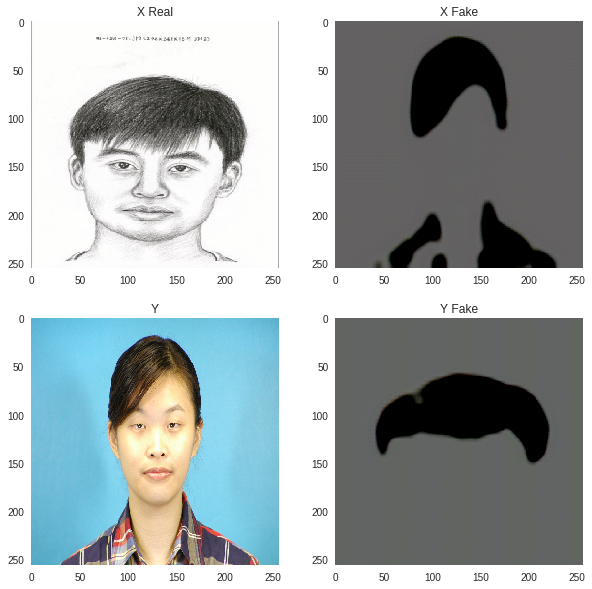

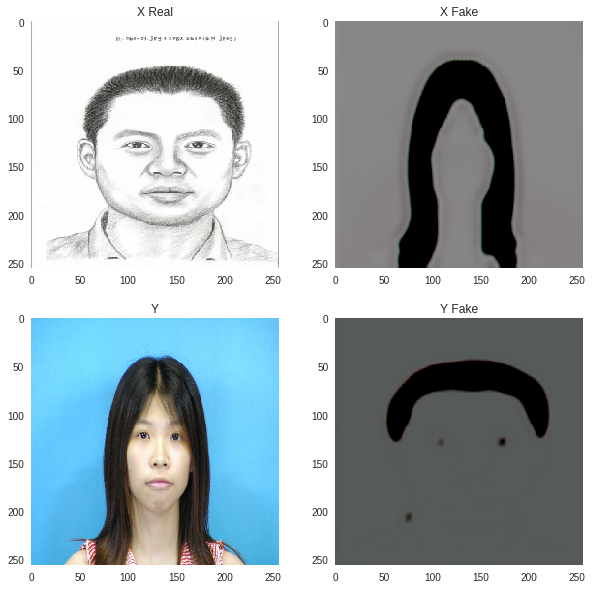

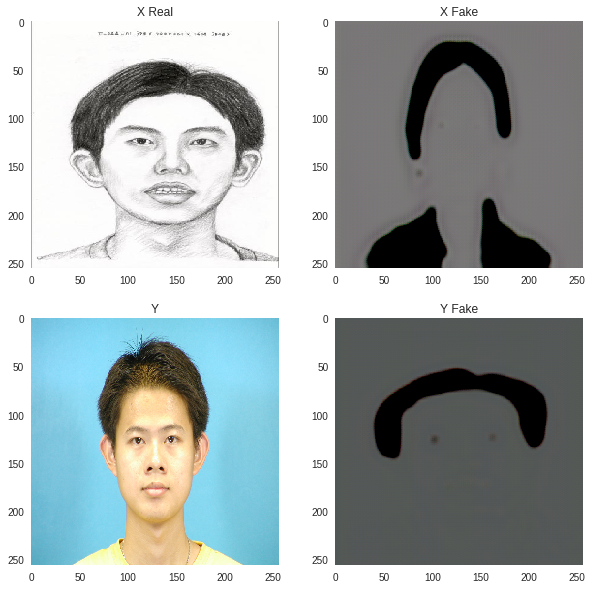

In [0]:
# Train
# 17:05 약 100 epochs
with tf.Session() as sess:
    # Build an init op for our variables
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    sess.run(init_op)
    
    print()
    # We'll also save our model so we can load it up again
#     saver = tf.train.Saver()

    saver = tf.train.import_meta_graph('./model_181126_003.ckpt-0.meta')
#     saver.restore(sess, './model2.ckpt-300')

  
  
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    
    
    writer = tf.summary.FileWriter(ckpt_path)



    
    for epoch_i in range(n_epochs):
        print("epoch : ", epoch_i)
        # You'll want to use the approriate batch generator here!
        for X, Y in batch_generator_dataset(ds_X, ds_Y):

            # First generate in both directions
            X_fake, Y_fake = sess.run(
                [net['X_fake'], net['Y_fake']],
                feed_dict={net['X_real']: X,
                           net['Y_real']: Y})

            # Now sample from history
            if it_i < capacity:
                # Not enough samples yet, fill up history buffer
                fake_Xs[idx] = X_fake
                fake_Ys[idx] = Y_fake
                idx = (idx + 1) % capacity
            elif np.random.random() > 0.5:
                # Swap out a random idx from history
                rand_idx = np.random.randint(0, capacity)
                fake_Xs[rand_idx], X_fake = X_fake, fake_Xs[rand_idx]
                fake_Ys[rand_idx], Y_fake = Y_fake, fake_Ys[rand_idx]
            else:
                # Use current generation
                pass

            # Optimize G Networks
            loss_G = sess.run(
                [net['loss_G'], G],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['Y_fake_sample']: Y_fake,
                    net['X_fake_sample']: X_fake
                })[0]

            # Optimize D_Y
            loss_D_Y = sess.run(
                [net['loss_D_Y'], D_Y],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['Y_fake_sample']: Y_fake
                })[0]

            # Optimize D_X
            loss_D_X = sess.run(
                [net['loss_D_X'], D_X],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['X_fake_sample']: X_fake
                })[0]

            print(it_i, 'G:', loss_G, 'D_X:', loss_D_X, 'D_Y:', loss_D_Y)

            # Update summaries
            if it_i % 100 == 0:
                summary = sess.run(
                    net['summaries'],
                    feed_dict={
                        net['X_real']: X,
                        net['Y_real']: Y,
                        net['X_fake_sample']: X_fake,
                        net['Y_fake_sample']: Y_fake
                    })
                writer.add_summary(summary, it_i)
            it_i += 1

        # Save
        if epoch_i % 50 == 0:
            saver.save(
                sess,
                os.path.join(ckpt_path, 'model_181126_004.ckpt'),
                global_step=epoch_i)
            
        # Show generative images:        
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        
        print('epochs: ', epoch_i)
        axs[0][0].set_title('X Real')
        # axs[0][0].imshow(np.clip(X[0], 0.0, 1.0))
        axs[0][0].imshow(X[0])
        axs[0][0].grid(False)

        axs[0][1].set_title('X Fake')
        # x_fake = (X_fake[0] + abs(X_fake[0].min())) / (X_fake[0].max() + abs(X_fake[0].min()))
        # axs[0][1].imshow(x_fake)
        axs[0][1].imshow(np.clip(X_fake[0], 0.0, 1.0))
        axs[0][1].grid(False)
        img = Image.fromarray(X_fake[0],"RGB")
        Fake_X = "x" + str(epoch_i) + ".png"
        img.save(Fake_X)
        # axs[0][1].imshow(img) 
        print('epochs:::: ', epoch_i)
        
        
        axs[1][0].set_title('Y')
        # axs[1][0].imshow(np.clip(Y[0], 0.0, 1.0))
        axs[1][0].imshow(Y[0])
        axs[1][0].grid(False)
        
        axs[1][1].set_title('Y Fake')
        # y_fake = (Y_fake[0] + abs(Y_fake[0].min())) / (Y_fake[0].max() + abs(Y_fake[0].min()))
        # axs[1][1].imshow(y_fake)
        axs[1][1].imshow(np.clip(Y_fake[0], 0.0, 1.0))
        axs[1][1].grid(False)
        img = Image.fromarray(Y_fake[0],"RGB")
        Fake_Y = "y" + str(epoch_i) + ".png"
        img.save(Fake_Y)
        # axs[1][1].imshow(img)
        fig.show();

In [0]:
with tf.Session() as sess:
    # Build an init op for our variables
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    sess.run(init_op)
    
    print()

In [2]:
training_vars

NameError: ignored